In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%load_ext rpy2.ipython
%R library(dplyr);library(magrittr);library(ggplot2)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['ggplot2', 'magrittr', 'dplyr', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [2]:
%%R
#create lists of methyltransferase locus tags to be extracted from annotation files
all<-read.csv("../data/all_annotations.20151109.txt", sep="\t", na.string="NA",header=FALSE)
all$V15<-NULL
colnames(all)<-c("phage","locus_tag","type","start","stop","strand","annotation","kegg","pfam","cog","eggnog","aclame","OM-RGC","cvp")
head(all)
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%nrow%>%print
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%group_by(annotation)%>%summarise(count=n())%>%print
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%.$locus_tag%>%write.table("nvp_methylases_lts.txt",col.names=FALSE,quote=FALSE,row.names=FALSE)
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%group_by(phage)%>%summarise%>%nrow
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%.[grepl("adenine",.$annotation, ignore.case=TRUE),]%>%.$locus_tag%>%write.table("nvp_adenine_methylases_lts.txt",col.names=FALSE,quote=FALSE,row.names=FALSE)
all[grepl("methyl",all$annotation, ignore.case=TRUE),]%>%.[grepl("cytosine",.$annotation, ignore.case=TRUE),]%>%.$locus_tag%>%write.table("nvp_cytosine_methylases_lts.txt",col.names=FALSE,quote=FALSE,row.names=FALSE)

[1] 150
Source: local data frame [5 x 2]

                                           annotation count
                                               (fctr) (int)
1                 C-5 cytosine-specific DNA methylase    60
2 D12 class N6 adenine-specific DNA methyltransferase    20
3                                       DNA methylase    25
4             DNA N-6-adenine-methyltransferase (Dam)    41
5                            Methyltransferase domain     4


In [75]:
!scp *methylases_lts.txt jbrown@eofe4.mit.edu:/nobackup1/jbrown/annotation/

nvp_adenine_methylases_lts.txt                100%  749     0.7KB/s   00:00    
nvp_cytosine_methylases_lts.txt               100%  721     0.7KB/s   00:00    
nvp_methylases_lts.txt                        100% 1822     1.8KB/s   00:00    


In [9]:
%%R
pts<-all[grepl("methyl.*ase",all$annotation, ignore.case=TRUE),]%>%.$phage%>%unique

In [23]:
%Rpull pts
pwm=[p.split("_")[1] for p in pts]


In [ ]:
#on server:
#grab methylases from vibriophages:
from pyfaidx import Fasta
f=Fasta("./orthomcl/phage_v_phage/goodProteins.fasta")

titles=list(f.keys())

tdict={}

for t in titles:
    lt=t.split("|")[1]
    tdict[lt]=t
    
alts=open("nvp_adenine_methylases_lts.txt").readlines()
aout=open("nvp_adenine_methylases.fasta","w")

clts=open("nvp_cytosine_methylases_lts.txt").readlines()
cout=open("nvp_cytosine_methylases.fasta","w")

for l in alts:
    if tdict.get(l.replace("\n",""),0)!=0:
        aout.write(">%s\n%s\n" % (l.replace("\n",""), str(f[tdict[l.replace("\n","")]])))
aout.close()

clts=open("nvp_cytosine_methylases_lts.txt").readlines()
cout=open("nvp_cytosine_methylases.fasta","w")

for l in clts:
    if tdict.get(l.replace("\n",""),0)!=0:
        cout.write(">%s\n%s\n" % (l.replace("\n",""), str(f[tdict[l.replace("\n","")]])))
cout.close()
        

#grab methyltransferases from vibrio genomes:
import sqlite3
conn=sqlite3.connect('/pool001/jbrown/HRX_Vibrio_lt_db.sqlite')
c=conn.cursor()
c.execute("SELECT * from products WHERE product LIKE '%methylase%' or product LIKE '%methyltransferase%'")
output=c.fetchall()
conn.close()

import re

output1=[]
for item in output:
    if re.search("(adenine|cytosine|DNA methylase)", item[2]): # and re.search("!(RNA)", item[2]):   
    #'phage methylases are mostly adenine and cytosine associated; 
    #grabbing proteins with similar names'
        output1.append(item)
        
adenine=[]
cytosine=[]
for item in output:
    if re.search("RNA", item[2]): # and re.search("!(RNA)", item[2]):   
    #'phage methylases are mostly adenine and cytosine associated; 
    #grabbing proteins with similar names'
        continue
    else:
        if re.search("(adenine)", item[2]):
            adenine.append(item)
        elif re.search("cytosine", item[2]):
            cytosine.append(item)

            
aout=open("Vibrio_adenine_methylases.fasta","w")
cout=open("Vibrio_cytosine_methylases.fasta","w")

for s in adenine:
    aout.write(">%s\n%s\n" % (s[0], s[3]))
aout.close()

for s in cytosine:
    cout.write(">%s\n%s\n" % (s[0], s[3]))
cout.close()


        
out=open("Vibrio_methylases.fasta","w")
out1=open("Vibrio_methylase_info.txt","w")
out1.write("host\tgene\tlocus_tag\tfunction\n")
for s in output2:
    out.write(">%s\n%s\n" % (s[0], s[3]))
    out1.write("%s\t%s\t%s\t%s\n" % (s[0].split("_")[0], s[0], s[1], s[2]))
out.close()
out1.close()

!cat Vibrio_methylases.fasta nvp_methylases.fasta > ph_methylases.fasta

In [4]:
!scp jbrown@eofe4.mit.edu:/nobackup1/jbrown/annotation/*methylases.fasta ../data/

host_methylases.fasta                         100%  312KB 312.5KB/s   00:00    
nvp_adenine_methylases.fasta                  100%   12KB  11.9KB/s   00:01    
nvp_cytosine_methylases.fasta                 100%   17KB  16.7KB/s   00:00    
nvp_methylases.fasta                          100%   34KB  33.9KB/s   00:00    
ph_adenine_methylases.fasta                   100%  107KB 107.3KB/s   00:00    
ph_cytosine_methylases.fasta                  100%   68KB  68.4KB/s   00:00    
ph_methylases.fasta                           100%  184KB 183.6KB/s   00:01    
Vibrio_adenine_methylases.fasta               100%   95KB  95.4KB/s   00:00    
Vibrio_cytosine_methylases.fasta              100%   52KB  51.7KB/s   00:00    
Vibrio_methylases.fasta                       100%  150KB 149.7KB/s   00:00    


In [1]:
from __future__ import print_function
import itertools

#Fasta iterator:
def read_fasta(file_handle):
    for header, group in itertools.groupby(file_handle, lambda line: line[0] == '>'):
        if header:
            line = group.next()
            name = line[1:].strip()
        else:
            seq = ''.join(line.strip() for line in group)
            yield name, seq
    
            
gzopen = lambda f: gzip.open(f) if f.endswith(".gz") else open(f)

def get_fasta_titles(fasta):
    names = []
    with open(fasta) as infile:
        for name, seq in read_fasta(infile):
            names.append(name)
    return names

In [42]:
with open("../data/ph_adenine_methylase_coldefs1.txt","w") as outfile:

    phage_titles = get_fasta_titles("../data/nvp_adenine_methylases.fasta")
    host_titles=get_fasta_titles("../data/Vibrio_adenine_methylases.fasta")

    phage_col="#97A761"
    host_col="#9D6188"

    for p in phage_titles:
        print("%s\trange\t%s\tphage\n" % (p, phage_col), file=outfile)
    for h in host_titles:
        print("%s\trange\t%s\thost\n" % (h, host_col), file=outfile)

In [43]:
with open("../data/ph_cytosine_methylase_coldefs1.txt", "w") as outfile:
    phage_titles = get_fasta_titles("../data/nvp_cytosine_methylases.fasta")
    host_titles = get_fasta_titles("../data/Vibrio_cytosine_methylases.fasta")
    phage_col="#97A761"
    host_col="#9D6188"
    
    for p in phage_titles:
        print("%s\trange\t%s\tphage\n" % (p, phage_col), file=outfile)
    for h in host_titles:
        print("%s\trange\t%s\thost\n" % (h, host_col), file=outfile)

In [9]:
from skbio import Alignment
from skbio.sequence import Protein
import seaborn as sns
from itolapi import Itol, ItolExport
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
%matplotlib inline

In [5]:
!muscle -in ../data/ph_adenine_methylases.fasta -out ../data/ph_adenine_methylases_aln1.fasta


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.


*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA

In [6]:
!muscle -in ../data/ph_cytosine_methylases.fasta -out ../data/ph_cytosine_methylases_aln1.fasta


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.


*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA sequence data, ignored

*** WARNING *** Invalid character '*' in FASTA

In [15]:
aln = Alignment.read('../data/ph_adenine_methylases_aln1.fasta', format='fasta')

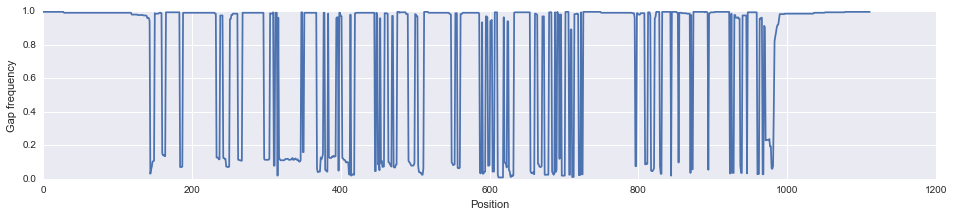

In [16]:
gap_freq = [d["-"] for d in aln.position_frequencies()]
fig, ax = plt.subplots()
fig.set_size_inches([16, 3])
ax.plot(np.arange(len(gap_freq)), gap_freq)
ax.set_xlabel("Position")
ax.set_ylabel("Gap frequency")

In [17]:
keepers, = np.where(np.array(gap_freq)<=0.20)
aln_masked = aln.subalignment(positions_to_keep=keepers)

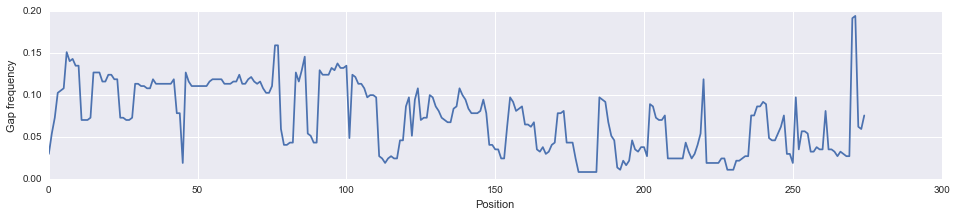

In [18]:
gap_freq2 = [d["-"] for d in aln_masked.position_frequencies()]
fig, ax = plt.subplots()
fig.set_size_inches([16, 3])
ax.plot(np.arange(len(gap_freq2)), gap_freq2)
ax.set_xlabel("Position")
ax.set_ylabel("Gap frequency")

In [19]:
aln_masked.write("../data/ph_adenine_methylases_aln1_masked.fasta")

In [22]:
!head -n2 ../data/ph_adenine_methylases_aln1_masked.fasta

>NVP1205O_24
PKDEKN--RWG------------------TLIECF-NDGQYLYGRPFEIDVCAEPETAKVNRFMV-----------APEWF--EARRLSSFVGDHKGFNLKP----------EQSIVGFDLQCDWGPNWWCNPPFD-------------------LKAEFIAKATEE----VRKGNPGMMLIPYEPLTARNTIEGVATRIYEPDGRYNFYEIDGETR-KSG-----VNFGCAFV--LFEGPT-----TPRQPFRRGIA------LNAFTC-----


In [34]:
!FastTree < ../data/ph_adenine_methylases_aln1_masked.fasta > ../data/ph_adenine_methylases.tree

FastTree Version 2.1.8 No SSE3
Alignment: standard input
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Ignored unknown character X (seen 296 times)
Initial topology in 0.04 seconds
Refining topology: 27 rounds ME-NNIs, 2 rounds ME-SPRs, 14 rounds ML-NNIs
Total branch-length 26.008 after 0.39 sec
ML-NNI round 1: LogLk = -20502.947 NNIs 31 max delta 21.95 Time 1.28
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 1.021 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -19943.813 NNIs 15 max delta 6.44 Time 2.28
ML-NNI round 3: LogLk = -19933.521 NNIs 7 max delta 7.21 Time 2.71
ML-NNI round 4: LogLk = -19933.396 NNIs 5

#### uploading and observing iTol plot

In [39]:
itol_uploader = Itol.Itol()
itol_uploader.add_variable('treeFile', '../data/ph_adenine_methylases.tree')
itol_uploader.add_variable('treeFormat', 'newick')
itol_uploader.add_variable('treeName', 'adenine1')
itol_uploader.add_variable("colorDefinitionFile", "../data/ph_adenine_methylase_coldefs1.txt")
status = itol_uploader.upload()
itol_uploader.comm.upload_output
print(itol_uploader.get_webpage())

http://itol2.embl.de/external.cgi?tree=2493143942765114572239970&restore_saved=1


### Make functions from previous exercise

In [52]:
def plot_gap_frequency(aln_file, fmt = 'fasta'):
    '''plot gap frequency across an alignment of similar sequences'''
    aln = Alignment.read(aln_file, format=fmt)
    gap_freq = [d["-"] for d in aln.position_frequencies()]
    fig, ax = plt.subplots()
    fig.set_size_inches([16, 3])
    ax.plot(np.arange(len(gap_freq)), gap_freq)
    ax.set_xlabel("Position")
    ax.set_ylabel("Gap frequency")

def mask_alignment(aln_file, out_aln, fmt='fasta', gap_thresh = 0):
    '''
    mask an alignment based on a specified gap frequency threshhold
    default threshold is 0
    '''
    aln = Alignment.read(aln_file, format=fmt)
    gap_freq = [d["-"] for d in aln.position_frequencies()]
    keepers, = np.where(np.array(gap_freq)<=gap_thresh)
    aln_masked = aln.subalignment(positions_to_keep=keepers)
    gap_freq2 = [d["-"] for d in aln_masked.position_frequencies()]
    fig, ax = plt.subplots()
    fig.set_size_inches([16, 3])
    ax.plot(np.arange(len(gap_freq2)), gap_freq2)
    ax.set_xlabel("Position")
    ax.set_ylabel("Gap frequency")
    aln_masked.write(out_aln)
    
def upload_itol_colordef_tree(tree_file_path, tree_name, color_def_path, fmt="newick"):
    '''
    upload tree file and color definition file to itol, returns a web address of tree
    '''
    itol_uploader = Itol.Itol()
    itol_uploader.add_variable('treeFile', tree_file_path)
    itol_uploader.add_variable('treeFormat', fmt)
    itol_uploader.add_variable('treeName', tree_name)
    itol_uploader.add_variable("colorDefinitionFile", color_def_path)
    status = itol_uploader.upload()
    itol_uploader.comm.upload_output
    print(itol_uploader.get_webpage())
    return itol_uploader.get_webpage()

def write_itol_phage_host_colordefs(output_file, phage_fasta, host_fasta, phage_hex="#97A761", host_hex="#9D6188"):
    with open("../data/ph_cytosine_methylase_coldefs1.txt", "w") as outfile:
        phage_titles = get_fasta_titles(phage_fasta)
        host_titles = get_fasta_titles(host_fasta)
        phage_col=phage_hex
        host_col=host_hex

        for p in phage_titles:
            print("%s\trange\t%s\tphage\n" % (p, phage_col), file=outfile)
        for h in host_titles:
            print("%s\trange\t%s\thost\n" % (h, host_col), file=outfile)

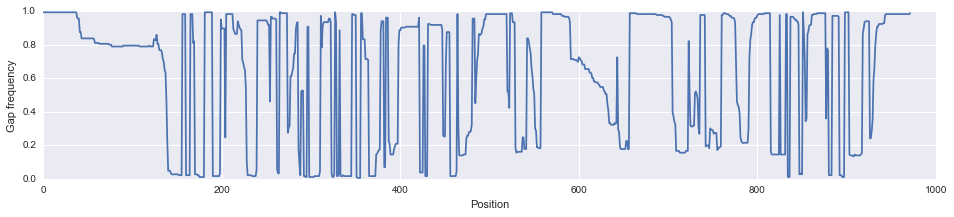

In [44]:
plot_gap_frequency("../data/ph_cytosine_methylases_aln1.fasta")

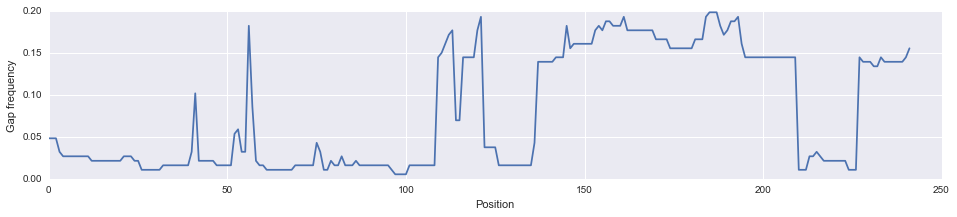

In [45]:
mask_alignment("../data/ph_cytosine_methylases_aln1.fasta", "../data/ph_cytosine_methylases_aln1_masked_0.2_.fasta", gap_thresh=0.2)

In [46]:
!FastTree <../data/ph_cytosine_methylases_aln1_masked_0.2_.fasta> ../data/ph_cytosine_tree1.tree

FastTree Version 2.1.8 No SSE3
Alignment: standard input
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Initial topology in 0.04 seconds
Refining topology: 28 rounds ME-NNIs, 2 rounds ME-SPRs, 14 rounds ML-NNIs
Total branch-length 29.759 after 0.43 sec
ML-NNI round 1: LogLk = -30410.266 NNIs 22 max delta 12.23 Time 1.27
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 1.130 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -28735.571 NNIs 7 max delta 5.59 Time 2.15
ML-NNI round 3: LogLk = -28721.066 NNIs 4 max delta 4.19 Time 2.50
ML-NNI round 4: LogLk = -28719.063 NNIs 0 max delta 0.00 Time 2.68
Turning off heuristi

In [50]:
webpage = upload_itol_colordef_tree('../data/ph_cytosine_tree1.tree', 'cytosine1', '../data/ph_cytosine_methylase_coldefs1.txt')

http://itol2.embl.de/external.cgi?tree=2493143943249314572253560&restore_saved=1
